In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1=pd.read_csv("Fx.csv",header=-1) #fnq= 41 oq=61  df1[fnq][oq]
df3=pd.read_csv("Fz.csv",header=-1)
df5=pd.read_csv("My.csv",header=-1)
matrixList=[df1,df3,df5]

In [3]:
ddf1=pd.read_csv("Fxd.csv",header=-1) #fnq= 41 oq=61  df1[fnq][oq]
ddf3=pd.read_csv("Fzd.csv",header=-1)
ddf5=pd.read_csv("Myd.csv",header=-1)
dmatrixList=[ddf1,ddf3,ddf5]

In [4]:
gg = 9.8
rho = 997
beta = 0.25
t = 0
dt = 0.1

In [5]:
class Wave:
    amp = 0.
    k = 0.
    omega = 0.
    phase = 0.
    def __init__(self, a, o, p):
        self.amp = a
        self.omega = o
        self.k = o*o/gg
        self.phase = p
    
    def get(self,x, t):
        return self.amp*math.sin(self.omega*t + self.k*x + self.phase)

    def calcF(self,x,t,Fn,omega_e,axis):
        fni = round(Fn/(1./40)) #0~40 
        omi = round(omega_e/(1./4)) #0~60
        # print(self.omega)
        j = round((axis-1)/2)
        # print(fni)
        # print(omi)
        coeff =  matrixList[j][fni][omi]*100 #N/cm -> N/m
        poffset= dmatrixList[j][fni][omi]
        output = coeff*self.amp*math.sin(self.omega*t + self.k*x + self.phase + poffset)  
        return output #N

In [6]:
class Water:
    waves = []
    def __init__(self, num, random_wave):
        self.waves = []
        if(random_wave==True):
            for i in range(num):
                newWave = Wave(random.uniform(0.001,0.005),random.uniform(5,10),random.uniform(1,10))
                self.waves.append(newWave)
        elif(num==0):
            self.waves.append(Wave(0,0,0))
        else:
            self.waves.append(Wave(0.1,10,0))
            
    def get(self,x,t):
        waveheight = 0
        for w in self.waves:
            waveheight += w.get(x,t)
        return waveheight

In [7]:
def calcFn(u,L):
    return math.fabs(u)/math.sqrt(9.8*L)

In [8]:
class Particle:
    posx = 0
    posz = 0
    velx = 0
    velz = 0
    accx = 0
    accz = 0
    
    angle = 0
    anglevel = 0
    angleacc = 0

    pl = 3.11
    ph = 0.34
    pw = 0.94
    pv = 0.0878
    mass = pv*100
    cgh = 0.340

    draught = 0

    def __init__(self,x,z):
        self.posx = x
        self.posz = z
        self.accx = 0
        self.accz = 0
        self.velx = 0
        self.velz = 0

    def calcAcc(self,en_thr):
        tFx=0
        tFz=0
        tM=0
        thr_f = 20

        cP = ww.get(self.posx,t)

        self.draught = min(max(cP-(self.posz-self.ph),0), self.ph)
        # print("d=" + "{:.2f}".format(self.draught))
            
        nx = math.cos(self.angle - math.pi/2)
        ny = math.sin(self.angle - math.pi/2)

        Fn = calcFn(self.velx,self.pl)
        # print(Fn)

        tFz -= self.mass*gg #Gravity
        
        if(self.draught>0):
            tFx += thr_f * math.cos(self.angle)
            tFz += thr_f * math.sin(self.angle)
            tFz += rho*self.draught*self.pw*self.pl*gg/50
            for w in ww.waves:
              omega_e = w.omega + w.omega**2 * self.velx / gg
              tFx += w.calcF(self.posx,t,Fn,omega_e,axis=1) - self.velx * 100
              tFz += w.calcF(self.posx,t,Fn,omega_e,axis=3) - self.velz * 100
              tM  += w.calcF(self.posx,t,Fn,omega_e,axis=5) - self.anglevel * 150
              # print(tFz)
        
        self.accx = tFx/self.mass
        self.accz = tFz/self.mass
        self.angleacc = tM/self.mass

    def update(self,en_thr):
      self.calcAcc(en_thr)
      self.velx += self.accx*dt
      self.velz += self.accz*dt
      self.anglevel += self.angleacc*dt
      self.posx += self.velx*dt
      self.posz += self.velz*dt
      self.angle += self.anglevel*dt
      # print("x=" + "{:.2f}".format(self.posx))
      # print("z=" + "{:.2f}".format(self.posz))

In [13]:
ww = Water(100,random_wave=True)
pp = Particle(0,0.19)
dt = 0.001
t=0
dl = []
xl = []
xvl = []
xal = []
zl = []
zvl= []
zal =[]
eng = []
pl = []

for i in range(10000):
    pp.update(en_thr=False)
    dl.append(pp.draught)
    xl.append(pp.posx)
    xvl.append(pp.velx)
    xal.append(pp.accx)
    zl.append(pp.posz)
    zvl.append(pp.velz)
    zal.append(pp.accz)
    pl.append(pp.angle)
    eng.append(pp.mass*pp.velz**2)
    t+=dt

(array([12., 15.,  8., 15., 10., 10.,  8., 12.,  5.,  5.]),
 array([5.00988886, 5.50363218, 5.9973755 , 6.49111882, 6.98486213,
        7.47860545, 7.97234877, 8.46609209, 8.95983541, 9.45357872,
        9.94732204]),
 <a list of 10 Patch objects>)

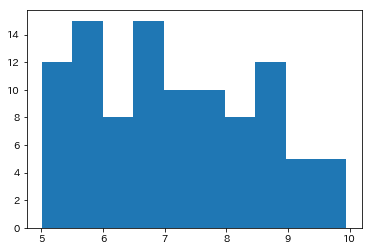

In [14]:
fig, ax = plt.subplots()

ol = []

for w in ww.waves:
    ol.append(w.omega)

ax.hist(ol)

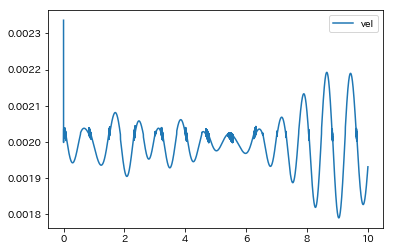

In [23]:
fig, ax = plt.subplots()
tdata = np.arange(0,10000*dt,dt)
# ax.set_ylim(-0.5,0.5)
# ax.plot(tdata,zl,label="pos")
# ax.plot(tdata,zvl,label="vel")
# ax.plot(tdata,zal,label="acc")
# ax.plot(tdata,dl,label="draught")
# ax.plot(tdata,eng,label="energy")
# ax.plot(tdata,pl,label="pitch angle")
# ax.plot(xl,zl)

ax.plot(tdata,xvl,label="vel")

ax.legend()

Text(0.5,1,'xvel')

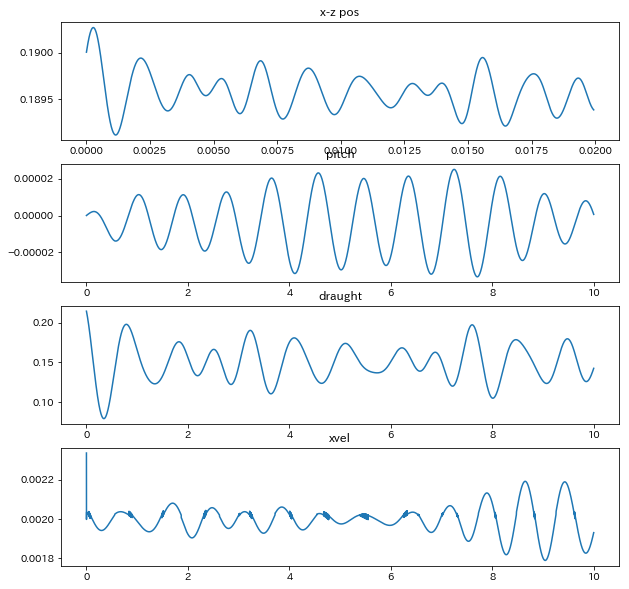

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,figsize=(10,10))

ax1.plot(xl,zl)
ax1.set_title('x-z pos')

ax2.plot(tdata,pl)
ax2.set_title('pitch')

ax3.plot(tdata,dl)
ax3.set_title('draught')

ax4.plot(tdata,xvl)
ax4.set_title('xvel')


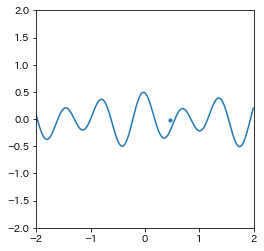

In [12]:


xdata = np.arange(-2,2,0.01)
ydata = np.array([ww.get(x,t) for x in xdata])
fig, ax = plt.subplots()
ax.set_xlim(-2.0,2.0)
ax.set_ylim(-2.0,2.0)
ax.set_aspect('equal', adjustable='box')

ax.plot(xdata,ydata)
ax.scatter(pp.posx,pp.posz,s=10)
t+=dt
pp.update(en_thr=False)

In [54]:
T=15
omega= 2*math.pi/T
omega

0.41887902047863906